In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from IPython.display import Image, display


In [2]:

GOOGLE_API_KEY=os.getenv("GEMINI_API_KEY1")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API")
HUGGINGFACE_API=os.getenv("HUGGINGFACE_API_KEY")
LANGCHAIN_PROJECT=os.getenv("LANGCHAIN_PROJECT") or "sample_agent_project"

In [3]:
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

C:\Users\prabigya\AppData\Local\Temp\ipykernel_10848\1814257612.py:7: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
c:\Users\prabigya\miniconda3\envs\lang_graph_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langchain_groq import ChatGroq
import os
llm=ChatGroq(model_name="Gemma2-9b-It")

In [6]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain import PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough , RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [7]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    input: str
    response: str

In [8]:
def generate_response(state: State) -> State:
    response = llm.invoke(state["input"])
    return {"response": response.content}

def refine_response(state: State) -> State:
    prompt = f"Refine this response to be more concise: {state['response']}"
    refined = llm.invoke(prompt)
    return {"response": refined.content}

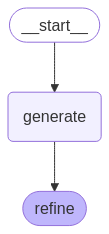

In [9]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate", generate_response)
graph_builder.add_node("refine", refine_response)

# Add edges
graph_builder.add_edge("generate", "refine")
#graph.add_edge("refine", END)

# Set the entry point
graph_builder.set_entry_point("generate")

# Compile the graph
graph = graph_builder.compile()


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
response=graph.invoke({"input":"Hello"})
response

{'input': 'Hello',
 'response': "Here are a few more concise options:\n\n* **Hi! What can I do for you?**\n* **Hello, how can I assist you?**\n* **What can I help you with?** \n\n\nLet me know if you'd like more variations! 😊 \n"}

# Integrate RAG in langgraph

In [11]:

loader=DirectoryLoader(r"C:\Users\prabigya\Desktop\work_here\langgraph_work\dataset_folder\txt_files",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=10
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [12]:

query = "rag vs finetune"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': 'C:\\Users\\prabigya\\Desktop\\work_here\\langgraph_work\\dataset_folder\\txt_files\\RAG_vs_FineTune.txt'}
From examining the two architectures of fine-tuning vs RAG, we can see a number of key differences, one of the most striking is the overall complexity of the RAG system: but we should be careful not
page_content='From examining the two architectures of fine-tuning vs RAG, we can see a number of key differences, one of the most striking is the overall complexity of the RAG system: but we should be careful not' metadata={'source': 'C:\\Users\\prabigya\\Desktop\\work_here\\langgraph_work\\dataset_folder\\txt_files\\RAG_vs_FineTune.txt'}
page_content='Key Decision Factors
When selecting between RAG and fine-tuning, consider these factors:' metadata={'source': 'C:\\Users\\prabigya\\Desktop\\work_here\\langgraph_work\\dataset_folder\\txt_files\\RAG_vs_FineTune.txt'}
page_content='RAG vs. Fine-Tuning: Use RAG for transparent solutions with dynamic data (e.g., customer-facing c

C:\Users\prabigya\AppData\Local\Temp\ipykernel_17780\573318122.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


In [13]:
def question_answer(AgentState: dict)->dict:
    message = AgentState["messages"]
    question=message[-1]

    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    #print(AgentState)
    
    return AgentState


In [14]:
present_agent_state={"messages":[]}

question="What is the tallest mountain?"
present_agent_state["messages"].append(question)

new_agent_state=question_answer(present_agent_state)
new_agent_state

{'messages': ['What is the tallest mountain?', 'Mount Everest. \n']}

In [15]:

from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [16]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [ ]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class TopicSelectorParser(BaseModel):
    topic: str= Field(description='Selected Topic')
    reasoning: str= Field(description="Reasoning behind topic selection")


parser = PydanticOutputParser(pydantic_object=TopicSelectorParser)


In [18]:
from pydantic import BaseModel, Field
class TopicSelectorParser(BaseModel):
    topic: str= Field(description='Selected Topic')
    reasoning: str= Field(description="Reasoning behind topic selection")


from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectorParser)

def categorize_user_question(AgentState: dict):
    message=AgentState["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.topic]}

In [19]:
class AgentState(TypedDict):
    problem: str
    research: str
    solution: str
    iterations: str

def researcher(state: AgentState) -> AgentState:
    research = llm.invoke(f"Research this problem: {state['problem']}")
    return {"research": research.content}

def solver(state: AgentState) -> AgentState:
    solution = llm.invoke(f"Given the research: {state['research']}, solve this problem: {state['problem']}")
    return {"solution": solution.content,"iteration":state.get("iterations",0)+1}


def should_continue(state: AgentState) -> str:
    if state.get("iterations",0) <3 and len(state.get("solution",""))<100:
        return "researcher"
    else:
        return END



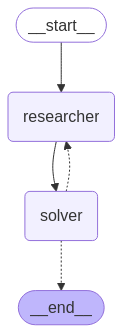

In [24]:
graph_builder= StateGraph(AgentState)

graph_builder.add_node("researcher",researcher)
graph_builder.add_node("solver",solver)

graph_builder.set_entry_point("researcher")


graph_builder.add_edge("researcher","solver")


graph_builder.add_conditional_edges(
    "solver",
    should_continue,
    path_map=[
        "researcher",
        "__end__"
    ]
        )

graph=graph_builder.compile()
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [25]:
result = graph.invoke({"problem": "How to optimize a neural network?"})
print(result["solution"])

This research breakdown already provides a fantastic answer to your question! 

Here's a summarized approach to optimizing a neural network based on the information given:

**1. Define Your Goal:**

* What task are you trying to achieve? (e.g., image classification, text generation, prediction)
* This determines the type of loss function you'll use.

**2. Choose Your Tools:**

* **Framework:** Select a deep learning library like TensorFlow, Keras, or PyTorch.
* **Hardware:** Consider using a GPU for faster training.

**3. Design Your Network Architecture:**

* Number of layers, types of layers (e.g., convolutional, recurrent), activation functions.
* This is often an iterative process based on experimentation and evaluation.

**4. Select a Loss Function:**

* **Regression:** Mean Squared Error (MSE)
* **Classification:** Cross-Entropy Loss
* Other options exist depending on your task.

**5. Pick an Optimization Algorithm:**

* **Gradient Descent Variants:**
    * **Batch Gradient Desce

In [26]:
result

{'problem': 'How to optimize a neural network?',
 'research': '## Optimizing a Neural Network: A Deep Dive\n\nOptimizing a neural network is crucial for achieving high performance. It involves finding the best set of weights and biases that minimize the difference between the network\'s predictions and the actual target values. \n\nHere\'s a breakdown of key aspects involved in neural network optimization:\n\n**1. Loss Function:**\n\n* **Purpose:** Measures the error between the network\'s output and the desired output.\n* **Types:** \n    * **Mean Squared Error (MSE):** Common for regression tasks.\n    * **Cross-Entropy Loss:**  Common for classification tasks.\n    * **Hinge Loss:**  Used in Support Vector Machines.\n* **Selection:** Choose a loss function appropriate for your task.\n\n**2. Optimization Algorithm:**\n\n* **Purpose:**  Updates the network\'s weights and biases iteratively to minimize the loss function.\n* **Popular Algorithms:**\n    * **Gradient Descent:**  Basic al

# Debate Langgraph

In [52]:
from typing import TypedDict, List, Dict
from pydantic import BaseModel, Field
from typing import Literal
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",temperature=0.9)
llm2=ChatGroq(model_name="llama-3.3-70b-versatile",temperature=0.9)

class WinnerIdentification(BaseModel):
    winner: Literal["A","B"]

winner_parser = PydanticOutputParser(pydantic_object=WinnerIdentification)

class DebateState(TypedDict):
    topic: str
    perspective_a: List[str]
    perspective_b: List[str]
    moderator_summaries: List[str]
    winner_list: List[str]
    next_turn: str
    turns_completed: int
    final_synthesis: str


def advocate_a(state: DebateState) ->DebateState:
    argument=llm.invoke(f" You are an expert debate strategist skilled in constructing compelling arguments. \
        Argue strongly in favor of the following topic, using well-researched facts, logical reasoning, and persuasive rhetoric. \
        Anticipate counterarguments and effectively refute them. \
                        The topic is: {state['topic']}\
                        If the opponent has made a point, directly counter it with strong reasoning: \
                        Respond to previous point of opponent if any: {state.get('perspective_b', [])[-1] if state.get('perspective_b') else ''}\
                            \
                            Keep your response concise yet impactful.")
    
    current_args_a=state.get("perspective_a",[])
    current_args_a.append(argument.content)
    print("A: Argument ",str(argument.content).replace("\n"," ").strip())
    return {"perspective_a": current_args_a,"next_turn":"b"}

def advocate_b(state: DebateState) ->DebateState:
    argument=llm2.invoke(f"You are a master debate strategist known for constructing compelling counterarguments.  \
        Argue powerfully **against** the following topic, using **strong evidence, logical reasoning, and factual support** to dismantle the opposing viewpoint.  \
        Ensure your argument is structured, persuasive, and difficult to refute. \
                        The topic is: {state['topic']}\
                        **Refute the opponent's latest point if available:** \
                        Respond to previous point of opponent if any: {state.get('perspective_b', [])[-1] if state.get('perspective_b') else ''}\
                            Make your response concise yet impactful.\
                                ")
    
    current_args_b=state.get("perspective_b",[])
    current_args_b.append(argument.content)

    print("B: Argument",str(argument.content).replace("\n"," ").strip())
    return {"perspective_b": current_args_b,"next_turn":"a"}

def moderator(state: DebateState):
    try:

        summary = llm.invoke(f"As a neutral moderator, summarize the current state of this debate on {state['topic']}:\n"
                            f"Perspective A: {state['perspective_a'][-1] if state['perspective_a'] else ''}\n"
                            f"Perspective B: {state['perspective_b'][-1] if state['perspective_b'] else ''}")
        current_summaries = state.get("moderator_summaries", [])
        current_summaries.append(summary.content)
        return {
            "moderator_summaries": current_summaries, "turns_completed": state.get("turns_completed",0)+1
        }
    except Exception as e:
        print(e)
        return {"round_success":"__end__"}

def winner_of_round(state: DebateState)-> DebateState:
    template = """
    You are an impartial judge tasked with determining the winner of a debate round. 

    Follow these steps:
    1. Carefully analyze the topic, Argument A, and Argument B.
    2. Objectively assess the strength, logic, and relevance of each argument.
    3. Decide the winner based solely on the merits of the arguments presented.

    Details:
    - Topic: {topic}
    - Argument A, A is speaking in favour of topic: {perspective_a}
    - Argument B, B is speaking against the topic: {perspective_b}

    {format_instructions}

    Please return only a dictionary with a single key `winner` and a value that is either `"A"` or `"B"`. No additional text or explanations.
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=["topic","perspective_a","perspective_b"],
                                    partial_variables={
                                        "format_instructions" : winner_parser.get_format_instructions()
                                        }
                                    )
    chain =  prompt | llm | winner_parser
    query={
    "topic":state["topic"],
    "perspective_a":state["perspective_a"][-1],
    "perspective_b":state["perspective_b"][-1]
    }
    winner=chain.invoke(query)
    print(f"Round Winner: {winner.winner}\n")
    winner_list= state.get("winner_list",[])
    winner_list.append(str(winner.winner))
    return {"winner_list":winner_list}

    
def synthesize_debate(state: DebateState) -> DebateState:
    synthesis = llm.invoke(f"Synthesize this entire debate on {state['topic']}:\n"
                          f"Perspective A arguments: {state['perspective_a']}\n"
                          f"Perspective B arguments: {state['perspective_b']}\n"
                          f"Moderator summaries: {state['moderator_summaries']}\n\n"
                          f"Provide a balanced view that acknowledges the strengths of both perspectives.")
    return {"final_synthesis": synthesis.content}
    


def debate_router(state: DebateState):
    if state.get("turns_completed",0) <3:
        return state["next_turn"]
    else:
        return "synthesize"


def error_occured(state: DebateState):
    return END


In [49]:
from langgraph.graph import StateGraph, END

# Ensure all necessary functions like advocate_a, advocate_b, etc., are defined properly
# Make sure you have all the required functions implemented (like advocate_a, moderator, etc.)

graph_builder = StateGraph(DebateState)

# Add nodes for each role or task
graph_builder.add_node("a", advocate_a)
graph_builder.add_node("b", advocate_b)
graph_builder.add_node("moderator", moderator)
graph_builder.add_node("synthesize", synthesize_debate)
graph_builder.add_node("round_winner", winner_of_round)
graph_builder.add_node("error_occured", error_occured)

# Safe lambda functions for conditional edges
graph_builder.add_conditional_edges("a", lambda state: state.get("success", True), {
    True: "b",
    False: "error_occured"
})

graph_builder.add_conditional_edges("b", lambda state: state.get("success", True), {
    True: "round_winner",
    False: "error_occured"  # Optional fallback if current_turn is invalid
})

graph_builder.add_conditional_edges("round_winner", lambda state: state.get("round_success", True), {
    False: "error_occured",
    True: "moderator"
})

graph_builder.add_conditional_edges("moderator", debate_router, {
    "a": "a",  # Return to advocate A if current turn is 'a'
    "synthesize": "synthesize",  # Transition to synthesis step
})

# graph_builder.add_edge("a","b")
# graph_builder.add_edge("b","round_winner")
graph_builder.add_edge("error_occured",END)

# graph_builder.add_edge()

# Final edge from 'synthesize' node to END
graph_builder.add_edge("synthesize", END)

# Set the entry point to "a"
graph_builder.set_entry_point("a")

# Compile the graph
app = graph_builder.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [50]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'a': Node(id='a', name='a', data=a(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'b': Node(id='b', name='b', data=b(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'moderator': Node(id='moderator', name='moderator', data=moderator(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'synthesize': Node(id='synthesize', name='synthesize', data=synthesize(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'round_winner': Node(id='round_winner', name='round_winner', data=round_winner(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'error_occured': Node(id='error_occured',

In [51]:
question="capitalism better than socialism"
initial_state: DebateState = {
    "topic": question,
    "perspective_a": [],
    "perspective_b": [],
    "moderator_summary": [],
    "winner_list": [],
    "current_turn": "a",
    "turns_completed": 0,
    "final_synthesis": ""
}

app.invoke(initial_state)

A: Argument  Capitalism, despite its flaws, demonstrably outperforms socialism in generating wealth and improving living standards.  The empirical evidence is overwhelming.  Countries embracing free markets consistently exhibit higher GDP per capita, lower poverty rates, and greater technological innovation than their socialist counterparts.  South Korea's dramatic economic ascent, contrasted with North Korea's stagnation, serves as a stark illustration.  This isn't mere correlation; it's a causal relationship driven by capitalism's inherent incentives.  **Counterargument 1:** *Socialism prioritizes equality over efficiency.*  While equality is a laudable goal,  socialist systems often achieve it through inefficient resource allocation and stifled innovation.  Central planning struggles to match the dynamism of market-driven competition, leading to shortages, surpluses, and a lack of responsiveness to consumer demand.  The historical failures of centrally planned economies in the Sovie

{'topic': 'capitalism better than socialism',
 'perspective_a': ['Capitalism, despite its flaws, demonstrably outperforms socialism in generating wealth and improving living standards.  The empirical evidence is overwhelming.  Countries embracing free markets consistently exhibit higher GDP per capita, lower poverty rates, and greater technological innovation than their socialist counterparts.  South Korea\'s dramatic economic ascent, contrasted with North Korea\'s stagnation, serves as a stark illustration.  This isn\'t mere correlation; it\'s a causal relationship driven by capitalism\'s inherent incentives.\n\n**Counterargument 1:** *Socialism prioritizes equality over efficiency.*  While equality is a laudable goal,  socialist systems often achieve it through inefficient resource allocation and stifled innovation.  Central planning struggles to match the dynamism of market-driven competition, leading to shortages, surpluses, and a lack of responsiveness to consumer demand.  The his